In [1]:
import sys

sys.path.append("..")

from tools.tools import (
    get_ts_data_for_graph,
    load_sample,
    graph_to_label_tensor,
    score
)
from tools.display_tools import plot_current_state_of_graph,simple_sample_display
from tools.baseline_methods import cross_correlation_for_causal_discovery
import pickle
import numpy as np
from IPython.display import HTML
import pandas as pd


In [2]:
from wetterdienst.provider.dwd.observation import (
    DwdObservationDataset,
    DwdObservationRequest,
    DwdObservationResolution,
)
import datetime


from datetime import datetime


In [3]:
G = pickle.load(open("resources/flood_G.p", "rb"))

In [4]:
bb_box = np.array(list(np.array([G.nodes[x]["p"] for x in G.nodes]).max(axis=0)) + list(np.array([G.nodes[x]["p"] for x in G.nodes]).min(axis=0)))

In [5]:
# somehow most stations only go until 2023. Select window from here.
requests = DwdObservationRequest(
    parameter=DwdObservationDataset.PRECIPITATION_MORE,
    resolution=DwdObservationResolution.DAILY,
    start_date=datetime(2019, 1, 1),
    end_date=datetime(2023, 1, 1),
    
)

In [6]:
res = requests.filter_by_bbox(bb_box[3],bb_box[2],bb_box[1],bb_box[0]-0.2).df

In [7]:
c1 = res["end_date"].dt.year() > 2022
c2 = res["start_date"].dt.year() < 2019

selection = []
for n in range(len(c1)):
    if c1[n] and c2[n]: 
        selection.append(n)
res = res[selection]

In [8]:
# remove some of the stations further away.
remove =["02887","04023", "03094", "00822", "03683", "01022", "01252", "01441", "00579", "07327", "05436", "05700", "01022", "06314"]
selection = []
for n,x in enumerate((res["station_id"])):
    if x not in remove:
        selection.append(n)
res = res[selection]

In [9]:
coords = res[["longitude", "latitude", "station_id"]].to_numpy()

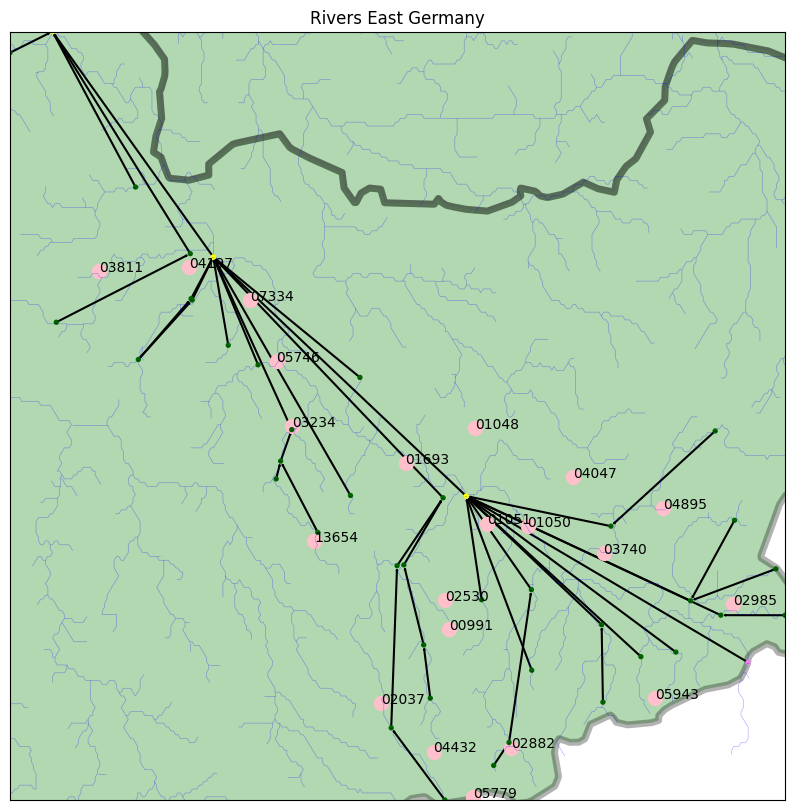

In [10]:
# Full Graph
plot_current_state_of_graph(
    G,
    lim=(bb_box[2], bb_box[0]),
    limx=(bb_box[3], bb_box[1]),
    dpi=50,
    node_size=8,
    save=0,
    river_map=True,
    ger_map=True,
    width=1.5,
    arrowsize=1,
    fs=(10, 10),
    font_size=1,
    extra_points=coords
)

In [11]:
stations = requests.filter_by_station_id(station_id=res["station_id"])

In [12]:
data = []
for result in stations.values.query():
    data.append(result.df[list(np.where(result.df["parameter"] == "precipitation_height")[0])])

stack = []
for x in data:
    name = x["station_id"][0]
    df = x["date", "value"].to_pandas()
    df.index = df.date.values
    df.drop(columns="date", inplace=True)
    df.columns = [name]
    stack.append(df)
prec = pd.concat(stack,axis=1)

/home/stein/anaconda3/envs/rivers1k/lib/python3.10/site-packages/wetterdienst/provider/dwd/observation/parser.py:151: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  df = df.drop(col for col in DROPPABLE_PARAMETERS if col in df.columns)


In [13]:
prec.isnull().sum()

00991       0
01048       0
01050       0
01051      24
01693       0
02037    1462
02530       0
02882       0
02985       0
03234       0
03740       0
03811       0
04047       0
04197       0
04432       0
04895       0
05746       0
05779      15
05943       1
07334       0
13654       0
dtype: int64

In [14]:
prec.drop(columns = ["02037"], inplace=True)

In [15]:
prec_sum = prec.sum(axis=1,skipna=False)

In [16]:
result = prec_sum.rolling(30,min_periods=30).mean()

In [17]:
mini = result.nsmallest(200)

In [18]:
mini[mini.index.day == 30]

2020-04-30     3.433333
2020-11-30     5.913333
2021-10-30     9.826667
2022-03-30    10.390000
2020-12-30    14.340000
2022-07-30    14.510000
2020-01-30    14.713333
2022-10-30    16.073333
dtype: float64

In [19]:
index = np.where(result.index == "2021-10-30")[0][0]

In [20]:
prec.iloc[index-29: index].sum(axis=1).mean()

10.16551724137931

In [21]:
data = pd.read_csv("resources/rivers_ts_east_germany.csv", index_col=0, )

In [22]:
data = data[[str(x) for x in list(G.nodes)]]

In [23]:
c1 = pd.to_datetime(data.index).year == 2021
c2 = pd.to_datetime(data.index).month == 10

In [25]:
data[c1 & c2].isnull().sum().values

array([  0,   0,   0,   0,   0,   0, 295,   0,   0,   0, 507,  35, 358,
         0,   0,   0,   0,   0,   0,   0,   6,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0])

<Axes: xlabel='datetime'>

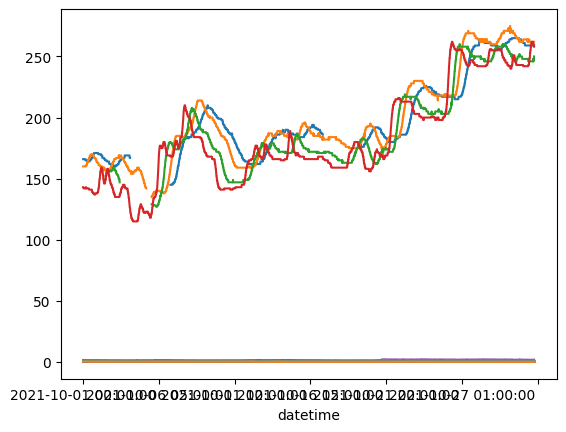

In [27]:
data[c1 & c2].plot(legend=False)

<Axes: >

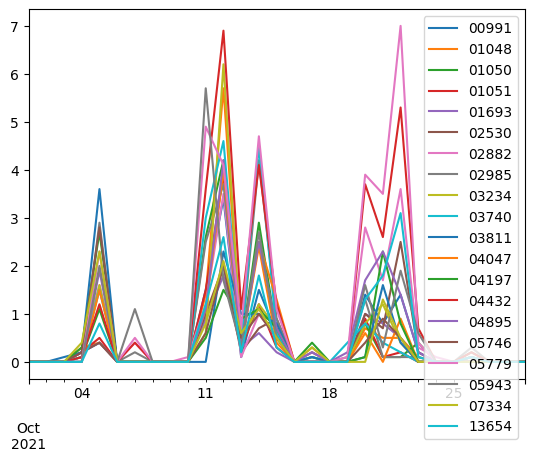

In [34]:
prec.iloc[index-29: index].plot()

<Axes: >

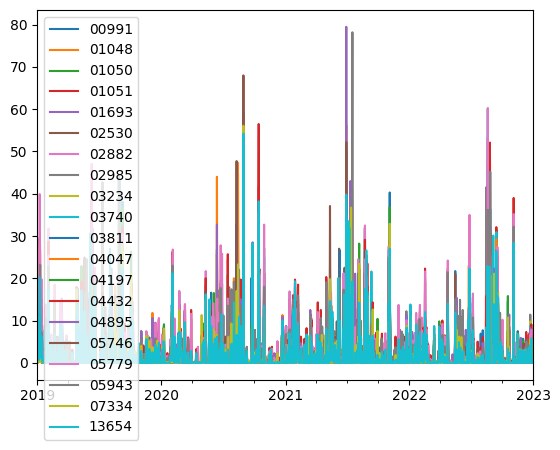

In [35]:
prec.plot()